In [1]:
import numpy as np
import scipy.constants as spc
import matplotlib.pyplot as plt
import ompy as om
import logging
import pandas as pd
import json

import scipy as sp
#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
om.__full_version__;
# For reproducability we seed the random generator.
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)

In [3]:
plt.rcParams["figure.dpi"] = 80
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.5

Import $\gamma$SF and NLD from Oslo Method

In [4]:
strength_nrm = np.genfromtxt("../analysis/mama/strength.nrm")
gsf_om = strength_nrm[18:60]
gsf_om_error = strength_nrm[79:-1]
n_d = len(gsf_om)

discrete_levels = np.genfromtxt("../analysis/mama/rholev.cnt") #Discrete levels 
rhopaw = np.genfromtxt("../analysis/mama/rhopaw.cnt") #experimental level density
fermigas = np.genfromtxt("../analysis/mama/fermigas.cnt")

nld_om = rhopaw[6:49]
nld_om_error = rhopaw[67:110]

Sn = 5.762
rhoSn = 28.07e6
rhoSn_error = 7.02e6

#from oslo method normalization
a0 = -0.8671
a1 = 0.1037
energy_gsf_om = np.linspace(999.9, 5252, len(gsf_om))
energy_nld_om = np.linspace(0, 5252-999.9, len(nld_om))
energy_discrete_levels = np.linspace(0, len(discrete_levels)-1, len(discrete_levels))
energy_fermigas = np.linspace(0, len(fermigas)-1, len(fermigas))
for i in range(len(gsf_om)):
    energy_gsf_om[i] = ((a0 + a1*energy_gsf_om[i])*1e1)*1e-3
for i in range(len(nld_om)):
    energy_nld_om[i] = ((a0 + a1*energy_nld_om[i])*1e1)*1e-3 
for i in range(len(discrete_levels)):
    energy_discrete_levels[i] = a0 + a1*energy_discrete_levels[i]
for i in range(len(fermigas)):
    energy_fermigas[i] = a0 + a1*energy_fermigas[i]
    

Import $\gamma$SF and NLD from OmPy

In [5]:
def getMedianQuantile(func):
    func = pd.DataFrame(func)
    func_median = pd.DataFrame.median(func)
    func_error_low = func.quantile(0.16)
    func_error_high = func.quantile(0.84)
    func_error = func_error_high - func_error_low
    return func_median, func_error

def read_ompy(path):
    """
    path must not include / at the end
    """
    energy_gsf = pd.read_csv(path+'/gsf_0.txt', sep=" ", header=None, skiprows=[0])[0]*1e-3
    energy_nld = pd.read_csv(path+'/nld_0.txt', sep=" ", header=None, skiprows=[0])[0]*1e-3
    gsf = np.zeros((99, len(energy_gsf)))
    nld = np.zeros((99, len(energy_nld)))
    
    for i in range(99):
        if i != 76:
            gsf[i] = pd.read_csv(path+'/gsf_%.0i.txt'%i, sep=" ", header=None, skiprows=[0])[1]
            nld[i] = pd.read_csv(path+'/nld_%.0i.txt'%i, sep=" ", header=None, skiprows=[0])[1]
    
    gsf_median, gsf_error = getMedianQuantile(gsf)
    nld_median, nld_error = getMedianQuantile(nld)
    
    return energy_gsf, gsf_median, gsf_error, energy_nld, nld_median, nld_error

path = '../analysis/OmPy/normalized_data/ensemble_simnorm_nld_gsf_250_kevperbin'

energy_gsf_ompy, gsf_ompy_median, gsf_ompy_error, energy_nld_ompy, nld_ompy_median, nld_ompy_error = read_ompy(path)

Import and convert experimental data from EXFOR

(I dont think i need this, since none of the exfor data is the right reaction)

In [6]:
with open('U233_exp_data.json') as K:
    data_U233 = json.load(K)
datasets_U233=data_U233["datasets"]




def cs_to_gsf(Eg, data):
    # input in MeV and milibarn -> use this conversion factor.
    exp = 8.684e-8# DOBBELTSJEKK TALLET! # pi**2 * hbar**2 * c**2
    return data*exp/Eg

def extract_JSON(data, x_i,y_i,yerror_i):
    """ Extracting data from input files from MAMA, adding them to useful arrays."""
    x = []; y = [] ; yerror = []

    for j in range(len(data)):
        y.append(data[j][y_i]) # MeV
        yerror.append(data[j][yerror_i]) # MeV
        x.append(data[j][x_i])

    x = np.array(x) ; y = np.array(y) ; yerror = np.array(yerror)
    return x,y,yerror



energy_exp1, gsf_exp1, gsf_exp1_error =  extract_JSON(datasets_U233[0]['data'], 0, 2, 3)
gsf_exp1 = cs_to_gsf(energy_exp1, gsf_exp1)
gsf_exp1_error = cs_to_gsf(energy_exp1, gsf_exp1_error)

energy_exp2, gsf_exp2, gsf_exp2_error =  extract_JSON(datasets_U233[1]['data'], 0, 2, 3)
gsf_exp2 = cs_to_gsf(energy_exp2, gsf_exp2)
gsf_exp2_error = cs_to_gsf(energy_exp2, gsf_exp2_error)

energy_exp3, gsf_exp3, gsf_exp3_error =  extract_JSON(datasets_U233[2]['data'], 0, 2, 3)
gsf_exp3 = cs_to_gsf(energy_exp3, gsf_exp3)
gsf_exp3_error = cs_to_gsf(energy_exp3, gsf_exp3_error)


"Does_it_work.cpp" 

Script to check the quality of the extracted
level density and strength function
by plotting exp. and calculated f.g. spectra
written by: ACL. June 7, 2012
Translated to Python January 2020 (tellefs)

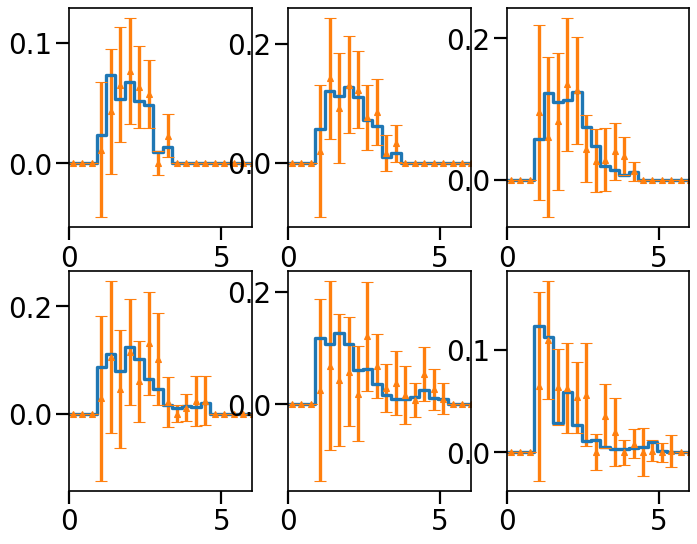

In [89]:
fg_theo_file = '../analysis/mama/fgteo.rsg'
fg_exp_file = '../analysis/mama/fg.rsg'
fg_exp_err_file = '../analysis/mama/fgerr.rsg'

def read_rsg(filename):
    infile = open(filename, 'r')
    matrix = []
    
    #extract calibration parameters:
    count = 0
    for line in infile:
        values = line.split()
        if not(values):
            count +=1
            continue
        elif line.startswith('!CALIBRATION'):
            values = line.split(',')
            x_cal = values[1:4]
            y_cal = values[4:7]
            for i in range(len(x_cal)):
                x_cal[i] = float(x_cal[i])*1e-3 #convert to float, convert from keV to MeV
                y_cal[i] = float(y_cal[i])*1e-3
            count+=1
        elif line.startswith('!DIMENSION'):
            values = line.split(':')
            x_dim = int(values[1].split(',')[0])
            y_dim = int(values[2])
            count+=1
        elif line.startswith('!'):
            count +=1
            continue
        else:
            for i in range(len(values)):
                values[i] = float(values[i])
            matrix.append(values)
            count +=1
            
    matrix = om.Matrix(matrix)
    
    infile.close()
    return matrix, x_cal, y_cal, x_dim, y_dim

fg_exp, x_cal_exp, y_cal_exp, x_dim_exp, y_dim_exp= read_rsg(fg_exp_file)
fg_exp_error, x_cal_exp_error, y_cal_exp_error, x_dim_exp_error, y_dim_exp_error = read_rsg(fg_exp_err_file)
fg_theo, x_cal_theo, y_cal_theo, x_dim_theo, y_dim_theo = read_rsg(fg_theo_file)

bin1, bin2, bin3, bin4, bin5, bin6 = 13, 14, 15, 16, 17, 18

bins = [36, 40, 45, 50, 55, 59]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(bins)):
    bin_no = bins[i]
    fg_theo_copy = fg_theo.copy()
    fg_theo_copy.cut('Ex', bin_no, bin_no+2)
    fg_theo_copy.Eg = x_cal_theo[0] + x_cal_theo[1]*fg_theo_copy.Eg + x_cal_theo[2]*fg_theo_copy.Eg**2
    fg_theo_copy.Ex = y_cal_theo[0] + y_cal_theo[1]*fg_theo_copy.Ex + y_cal_theo[2]*fg_theo_copy.Ex**2
    theo_y, theo_x = fg_theo_copy.projection('Eg')
    
    
    fg_exp_copy = fg_exp.copy()
    fg_exp_copy.cut('Ex', bin_no, bin_no+2)
    fg_exp_copy.Eg = x_cal_exp[0] + x_cal_exp[1]*fg_exp_copy.Eg + x_cal_exp[2]*fg_exp_copy.Eg**2
    fg_exp_copy.Ex = y_cal_exp[0] + y_cal_exp[1]*fg_exp_copy.Ex + y_cal_exp[2]*fg_exp_copy.Ex**2
    exp_y, exp_x = fg_exp_copy.projection('Eg');
    
    fg_exp_error_copy = fg_exp_error.copy()
    fg_exp_error_copy.cut('Ex', bin_no, bin_no+2)
    fg_exp_error_copy.Eg = x_cal_exp_error[0] + x_cal_exp_error[1]*fg_exp_error_copy.Eg + x_cal_exp_error[2]*fg_exp_error_copy.Eg**2
    fg_exp_error_copy.Ex = y_cal_exp_error[0] + y_cal_exp_error[1]*fg_exp_copy.Ex + y_cal_exp_error[2]*fg_exp_error_copy.Ex**2
    exp_err_y, exp_err_x = fg_exp_error_copy.projection('Eg');
    
    theo_y = theo_y[0:-1:3]
    theo_x = theo_x[0:-1:3]
    exp_y = exp_y[0:-1:3]
    exp_x = exp_x[0:-1:3]
    exp_err_y = exp_err_y[0:-1:3]
    exp_err_x = exp_err_x[0:-1:3]
    
    
    axes[i].step(theo_x, theo_y, where='mid')
    
    
    axes[i].errorbar(exp_x, exp_y, yerr=exp_err_y, marker='^', linestyle='')
    
    
    
    
    axes[i].set_xlim(0, 6)

fig.show()

Comparison with theorietical GEDR models (Giant Electric Dipole Resonance)

In [8]:
#declare constants 

Gamma_r1 = 1.78 #FWHM of resonance
E_r1 = 11.10 #energy of resonance
sigma_r1 = 313.5 #cross section of resonance


Gamma_r2 = 5.26
E_r2 = 13.97
sigma_r2 = 958.4

factor = 8.684e-8 # pi**2 * hbar**2 * c**2 in in mb^(-1) MeV^(-2)


T_f = 1 #temperature of final states
hbar = spc.hbar
c = spc.c

#declare functions

def SLo(E_gamma, Gamma_r, E_r, sigma_r):
    """
    Standard Lorentzian
    """
    denominator = (E_gamma**2 - E_r**2)**2 + Gamma_r**2 * E_gamma**2
    
    return factor * sigma_r * Gamma_r**2 * E_gamma /denominator


#double StandLor(double E_g, double E_r, double Gamma_r, double sigma_r){
#	double SLo = 0.;
#	double denominator = (pow(E_g,2.0) - pow(E_r,2.0))*(pow(E_g,2.0) - pow(E_r,2.0)) + pow(Gamma_r,2.0)*pow(E_g,2.0);
	
#	SLo = factor*sigma_r*pow(Gamma_r,2.0)*E_g/denominator;
#	return SLo;



def EGLo(E_gamma, Gamma_r, E_r, sigma_r, T_f):
    """
    Enhanced Generalized Lorentzian
    """
    Gamma_E_gamma = Gamma_r * (E_gamma**2 + 4 * np.pi**2 * T_f**2) / E_r**2
    Gamma_zero = Gamma_r * (4 * np.pi**2 * T_f**2) / E_r**2
    
    factor = sigma_r * Gamma_r * 8.68e-8
    
    A = E_gamma * Gamma_E_gamma / ( (E_gamma**2 + E_r**2)**2 + E_gamma**2 * Gamma_E_gamma**2 )
    
    B = 0.7 * Gamma_zero / E_r**3
    
    return factor * (A + B)





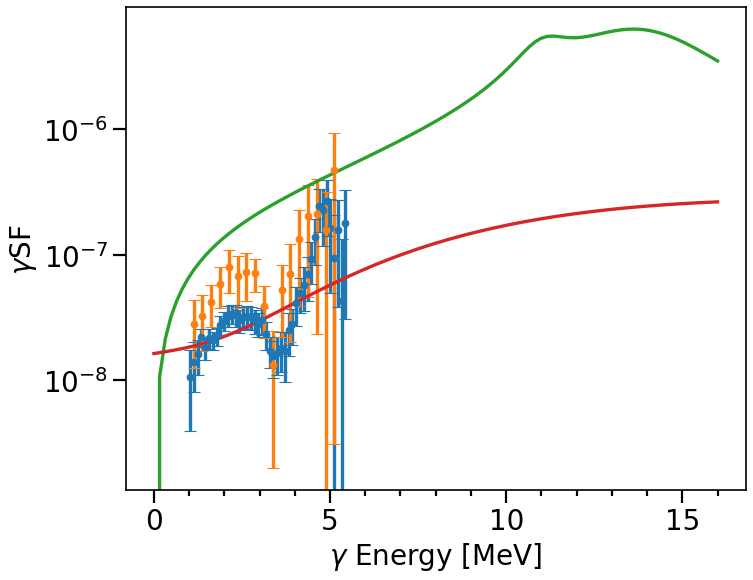

In [9]:
fig, ax = plt.subplots()

#This experiment
ax.errorbar(x=energy_gsf_om, y=gsf_om, yerr=gsf_om_error, marker='o', linestyle='')
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, marker='o', linestyle='')

#Experimental
#ax.errorbar(energy_exp1, gsf_exp1, yerr=gsf_exp1_error, x_err=None, fmt="o", color='green', label="")
#ax.errorbar(energy_exp2, gsf_exp2, yerr=gsf_exp2_error, x_err=None, fmt="o", color='red', label="")
#ax.errorbar(energy_exp3, gsf_exp3, yerr=gsf_exp3_error, x_err=None, fmt="o", color='blue', label="")

#Theoretical
energy_plotting = np.linspace(0, 16, 100)
ax.plot(energy_plotting, SLo(energy_plotting, Gamma_r1, E_r1, sigma_r1) + SLo(energy_plotting, Gamma_r2, E_r2, sigma_r2))

ax.plot(energy_plotting, EGLo(energy_plotting, Gamma_r1, E_r1, sigma_r1, 0.35) + EGLo(energy_plotting, Gamma_r2, E_r2, sigma_r2, 0.35))


#ax.set_ylim(1e-9, 2e-6)
#ax.set_ylim(1e47, 1e53)
#ax.set_xlim(0, 7)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$\gamma$ Energy [MeV]')
ax.set_ylabel('$\gamma$SF')

fig.show()

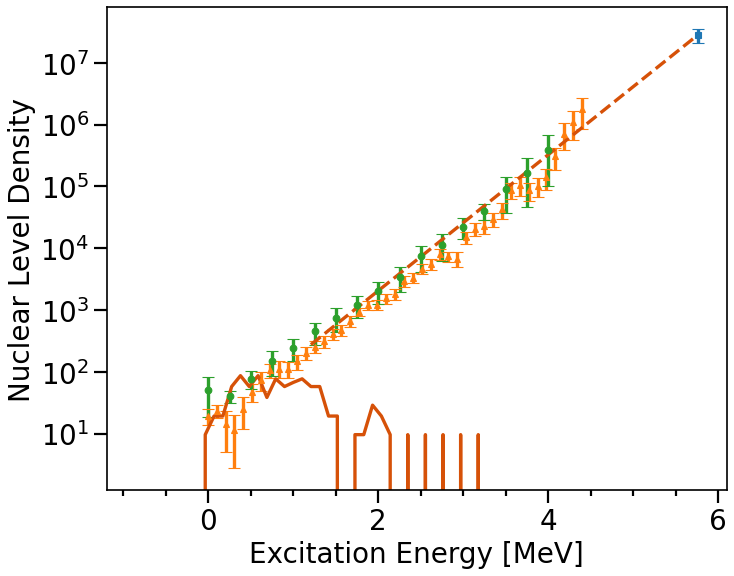

In [10]:
fig, ax = plt.subplots()
ax.errorbar(x=Sn, y=rhoSn, yerr=rhoSn_error, marker='s', linestyle='')
ax.errorbar(x=energy_nld_om, y=nld_om, yerr=nld_om_error, marker='^', linestyle='')
ax.errorbar(x=energy_nld_ompy, y=nld_ompy_median, yerr=nld_ompy_error, marker='o', linestyle='')
ax.set_yscale('log')

plt.plot(energy_fermigas[20:65], fermigas[20:65], "--", color="#D65108", label="CT interpolation")

plt.plot(energy_discrete_levels, discrete_levels, color="#D65108", label="Known levels")

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('Excitation Energy [MeV]')
ax.set_ylabel('Nuclear Level Density')

fig.show()
